# IMPORTING THE LIBRARIES

In [7]:
import os
import pandas as pd
import pickle
import numpy as np
import seaborn as sns
from sklearn.datasets import load_files
from keras.utils import np_utils
import matplotlib.pyplot as plt
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from keras.preprocessing import image                  
from tqdm import tqdm

import seaborn as sns
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score

TypeError: Unable to convert function return value to a Python type! The signature was
	() -> handle

In [3]:
# Pretty display for notebooks
%matplotlib inline

In [4]:
!ls

Custom CNN Batchwise.ipynb
Custom CNN Non Batch.ipynb
Model Prediction Results.ipynb
VGG16 Fine Tuned Layer Freezing Non Batch.ipynb
VGG16 FineTuning Layer Freezing Batchwise.ipynb
VGG16 Shallow Deep Non Batch.ipynb
VGG16 Shallow Network Batchwise.ipynb
VGG16 Shallow Non Batch.ipynb
csv_files
imgs
model
pickle_files


# Defining the train,test and model directories

We will create the directories for train,test and model training paths if not present

In [5]:
TEST_DIR = os.path.join(os.getcwd(),"imgs","test")
TRAIN_DIR = os.path.join(os.getcwd(),"imgs","train")
MODEL_PATH = os.path.join(os.getcwd(),"model","self_trained")
PICKLE_DIR = os.path.join(os.getcwd(),"pickle_files")
CSV_DIR = os.path.join(os.getcwd(),"csv_files")

In [6]:
TEST_DIR

'c:\\Users\\KUMAR\\Desktop\\cnn\\Distracted-Driver-Detection\\Training Notebooks\\imgs\\test'

In [7]:
if not os.path.exists(TEST_DIR):
    os.makedirs(TEST_DIR)
    print("Testing data does not exists")
if not os.path.exists(TRAIN_DIR):
    os.makedirs(TRAIN_DIR)
    print("Training data does not exists")
if not os.path.exists(MODEL_PATH):
    print("Model path does not exists")
    os.makedirs(MODEL_PATH)
    print("Model path created")
if not os.path.exists(PICKLE_DIR):
    os.makedirs(PICKLE_DIR)
if not os.path.exists(CSV_DIR):
    os.makedirs(CSV_DIR)

# Data Preparation

We will create a csv file having the location of the files present for training and test images and their associated class if present so that it is easily traceable.

In [8]:
def create_csv(DATA_DIR,filename):
    class_names = os.listdir(DATA_DIR)
    data = list()
    if(os.path.isdir(os.path.join(DATA_DIR,class_names[0]))):
        for class_name in class_names:
            file_names = os.listdir(os.path.join(DATA_DIR,class_name))
            for file in file_names:
                data.append({
                    "Filename":os.path.join(DATA_DIR,class_name,file),
                    "ClassName":class_name
                })
    else:
        class_name = "test"
        file_names = os.listdir(DATA_DIR)
        for file in file_names:
            data.append(({
                "FileName":os.path.join(DATA_DIR,file),
                "ClassName":class_name
            }))
    data = pd.DataFrame(data)
    data.to_csv(os.path.join(os.getcwd(),"csv_files",filename),index=False)

create_csv(TRAIN_DIR,"train.csv")
create_csv(TEST_DIR,"test.csv")
data_train = pd.read_csv(os.path.join(os.getcwd(),"csv_files","train.csv"))
data_test = pd.read_csv(os.path.join(os.getcwd(),"csv_files","test.csv"))


In [9]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22424 entries, 0 to 22423
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Filename   22424 non-null  object
 1   ClassName  22424 non-null  object
dtypes: object(2)
memory usage: 350.5+ KB


In [10]:
data_train['ClassName'].value_counts()

ClassName
c0    2489
c3    2346
c4    2326
c6    2325
c2    2317
c5    2312
c1    2267
c9    2129
c7    2002
c8    1911
Name: count, dtype: int64

In [11]:
data_train.describe()

,Filename,ClassName
count,22424,22424
unique,22424,10
top,c:\Users\KUMAR\Desktop\cnn\Distracted-Driver-D...,c0
freq,1,2489


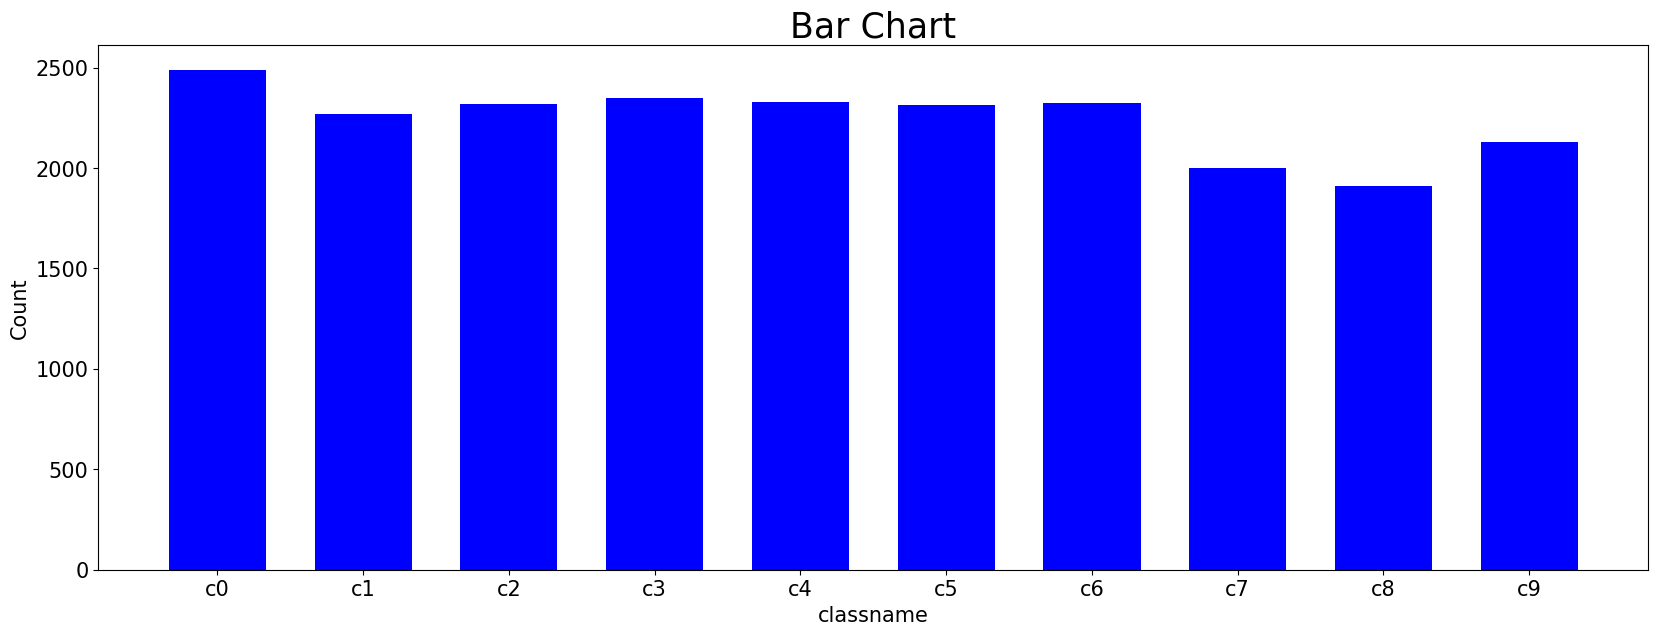

In [12]:


nf = data_train['ClassName'].value_counts(sort=False)
labels = data_train['ClassName'].value_counts(sort=False).index.tolist()
y = np.array(nf)
width = 1/1.5
N = len(y)
x = range(N)

fig = plt.figure(figsize=(20,15))
ay = fig.add_subplot(211)

plt.xticks(x, labels, size=15)
plt.yticks(size=15)

ay.bar(x, y, width, color="blue")

plt.title('Bar Chart',size=25)
plt.xlabel('classname',size=15)
plt.ylabel('Count',size=15)

plt.show()

In [13]:
data_test.head()

,FileName,ClassName
0,c:\Users\KUMAR\Desktop\cnn\Distracted-Driver-D...,test
1,c:\Users\KUMAR\Desktop\cnn\Distracted-Driver-D...,test
2,c:\Users\KUMAR\Desktop\cnn\Distracted-Driver-D...,test
3,c:\Users\KUMAR\Desktop\cnn\Distracted-Driver-D...,test
4,c:\Users\KUMAR\Desktop\cnn\Distracted-Driver-D...,test


In [14]:
data_test.shape

(79726, 2)

## Observation:
1. There are total 22424 training samples
2. There are total 79726 training samples
3. The training dataset is equally balanced to a great extent and hence we need not do any downsampling of the data

## Converting into numerical values

In [15]:
labels_list = list(set(data_train['ClassName'].values.tolist()))
labels_id = {label_name:id for id,label_name in enumerate(labels_list)}
print(labels_id)
data_train['ClassName'].replace(labels_id,inplace=True)

{'c1': 0, 'c0': 1, 'c8': 2, 'c3': 3, 'c7': 4, 'c5': 5, 'c9': 6, 'c4': 7, 'c2': 8, 'c6': 9}


C:\Users\KUMAR\AppData\Local\Temp\ipykernel_15044\1324950157.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_train['ClassName'].replace(labels_id,inplace=True)
C:\Users\KUMAR\AppData\Local\Temp\ipykernel_15044\1324950157.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_train['ClassN

In [16]:
with open(os.path.join(os.getcwd(),"pickle_files","labels_list.pkl"),"wb") as handle:
    pickle.dump(labels_id,handle)

In [17]:
labels = to_categorical(data_train['ClassName'])
print(labels.shape)

(22424, 10)


## Splitting into Train and Test sets

In [18]:
from sklearn.model_selection import train_test_split

xtrain,xtest,ytrain,ytest = train_test_split(data_train.iloc[:,0],labels,test_size = 0.2,random_state=42)

### Converting into 64*64 images 
You can substitute 64,64 to 224,224 for better results only if ram is >32gb

In [27]:
from keras_preprocessing.image import load_img, img_to_array



In [30]:

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = load_img(img_path, target_size=(128, 128))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [21]:
from keras_preprocessing.image import load_img, img_to_array


In [31]:

from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(xtrain).astype('float32')/255 - 0.5


In [32]:
valid_tensors = paths_to_tensor(xtest).astype('float32')/255 - 0.5



















































































































































































































































































































































































100%|██████████| 4485/4485 [00:12<00:00, 346.23it/s]


In [20]:
##takes too much ram 
## run this if your ram is greater than 16gb 
# test_tensors = paths_to_tensor(data_test.iloc[:,0]).astype('float32')/255 - 0.5 

# Defining the Model

In [33]:
model = Sequential()

model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(128,128,3), kernel_initializer='glorot_normal'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu', kernel_initializer='glorot_normal'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=256, kernel_size=2, padding='same', activation='relu', kernel_initializer='glorot_normal'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=512, kernel_size=2, padding='same', activation='relu', kernel_initializer='glorot_normal'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(500, activation='relu', kernel_initializer='glorot_normal'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax', kernel_initializer='glorot_normal'))


model.summary()

  0%|          | 0/17939 [11:59<?, ?it/s]

Model: "sequential"


_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       32896     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 256)       131328    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 256)      0         
 2D)      

In [34]:
plot_model(model,to_file=os.path.join(MODEL_PATH,"model_distracted_driver.png"),show_shapes=True,show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [35]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [37]:
filepath = os.path.join(MODEL_PATH,"distracted-{epoch:02d}-{val_accuracy:.2f}.hdf5")
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max',period=1, save_freq='epoch')
callbacks_list = [checkpoint]

In [40]:
model_history = model.fit(train_tensors,ytrain,validation_data = (valid_tensors, ytest),epochs=5, batch_size=40, shuffle=True,callbacks=callbacks_list)

Epoch 1/5
449/449 [==============================] - ETA: 0s - loss: 0.0749 - accuracy: 0.9793
Epoch 1: val_accuracy improved from 0.96143 to 0.98997, saving model to c:\Users\KUMAR\Desktop\cnn\Distracted-Driver-Detection\Training Notebooks\model\self_trained\distracted-01-0.99.hdf5
449/449 [==============================] - 231s 514ms/step - loss: 0.0749 - accuracy: 0.9793 - val_loss: 0.0409 - val_accuracy: 0.9900
Epoch 2/5
449/449 [==============================] - ETA: 0s - loss: 0.0651 - accuracy: 0.9817
Epoch 2: val_accuracy did not improve from 0.98997
449/449 [==============================] - 232s 518ms/step - loss: 0.0651 - accuracy: 0.9817 - val_loss: 0.0480 - val_accuracy: 0.9893
Epoch 3/5
449/449 [==============================] - ETA: 0s - loss: 0.0537 - accuracy: 0.9853
Epoch 3: val_accuracy did not improve from 0.98997
449/449 [==============================] - 231s 514ms/step - loss: 0.0537 - accuracy: 0.9853 - val_loss: 0.0553 - val_accuracy: 0.9882
Epoch 4/5
449/449 [

  0%|          | 0/17939 [1:43:28<?, ?it/s]


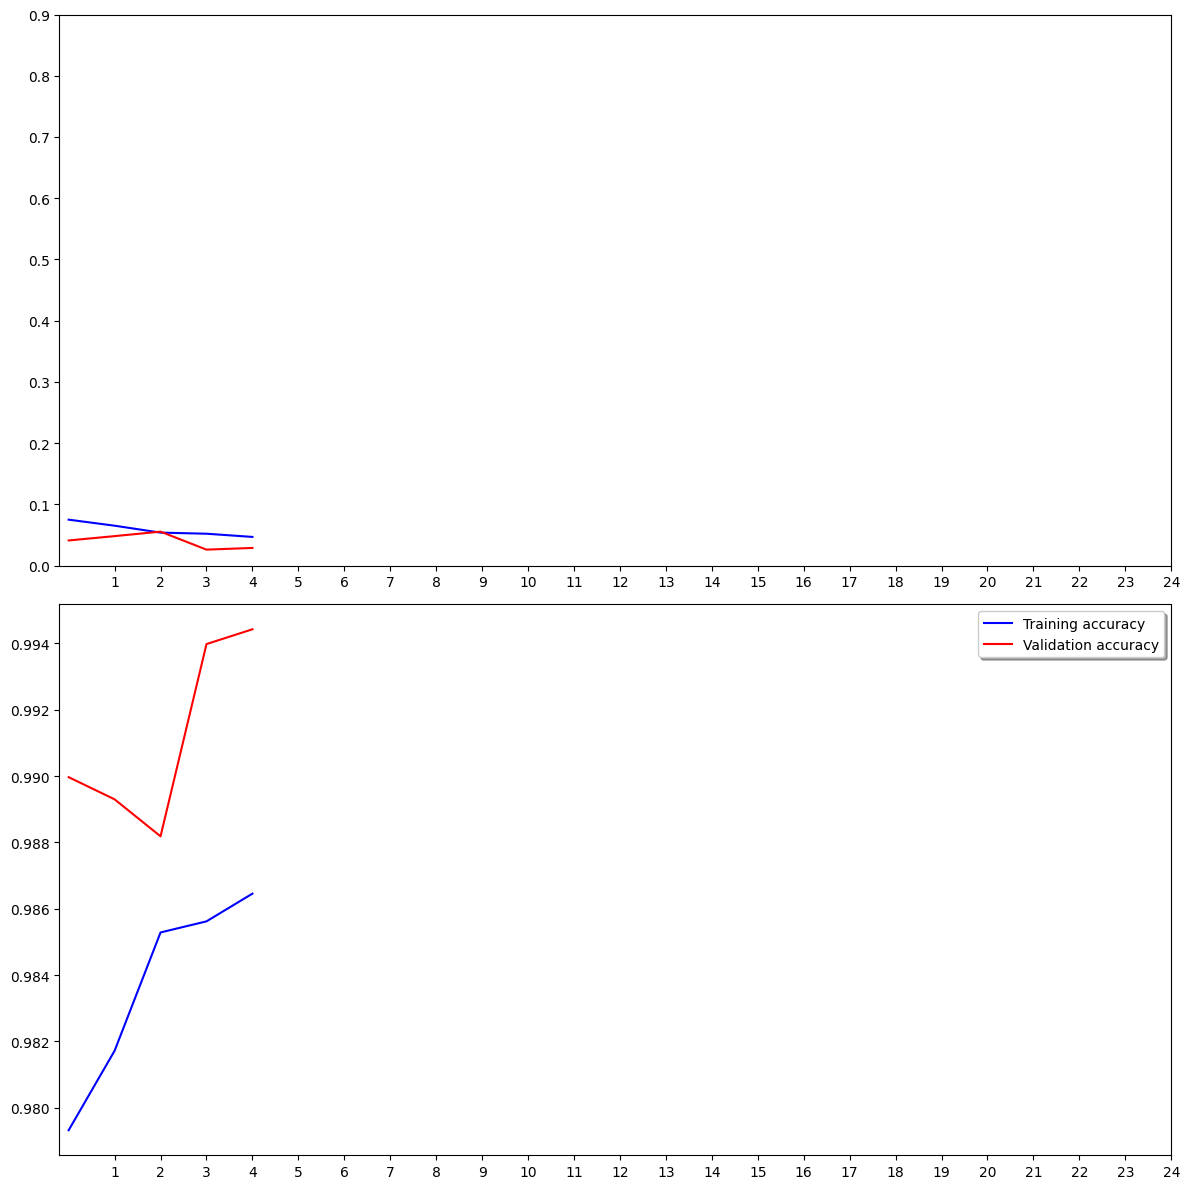

In [41]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(model_history.history['loss'], color='b', label="Training loss")
ax1.plot(model_history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, 25, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(model_history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(model_history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, 25, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

# Model Analysis

Finding the Confusion matrix,Precision,Recall and F1 score to analyse the model thus created 

In [42]:

def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    fig.savefig(os.path.join(MODEL_PATH,"confusion_matrix.png"))
    return fig


In [43]:
def print_heatmap(n_labels, n_predictions, class_names):
    labels = n_labels #sess.run(tf.argmax(n_labels, 1))
    predictions = n_predictions #sess.run(tf.argmax(n_predictions, 1))

#     confusion_matrix = sess.run(tf.contrib.metrics.confusion_matrix(labels, predictions))
    matrix = confusion_matrix(labels.argmax(axis=1),predictions.argmax(axis=1))
    row_sum = np.sum(matrix, axis = 1)
    w, h = matrix.shape

    c_m = np.zeros((w, h))

    for i in range(h):
        c_m[i] = matrix[i] * 100 / row_sum[i]

    c = c_m.astype(dtype = np.uint8)

    
    heatmap = print_confusion_matrix(c, class_names, figsize=(18,10), fontsize=20)


In [44]:
class_names = list()
for name,idx in labels_id.items():
    class_names.append(name)
# print(class_names)
ypred = model.predict(valid_tensors)

141/141 [==============================] - 13s 92ms/step


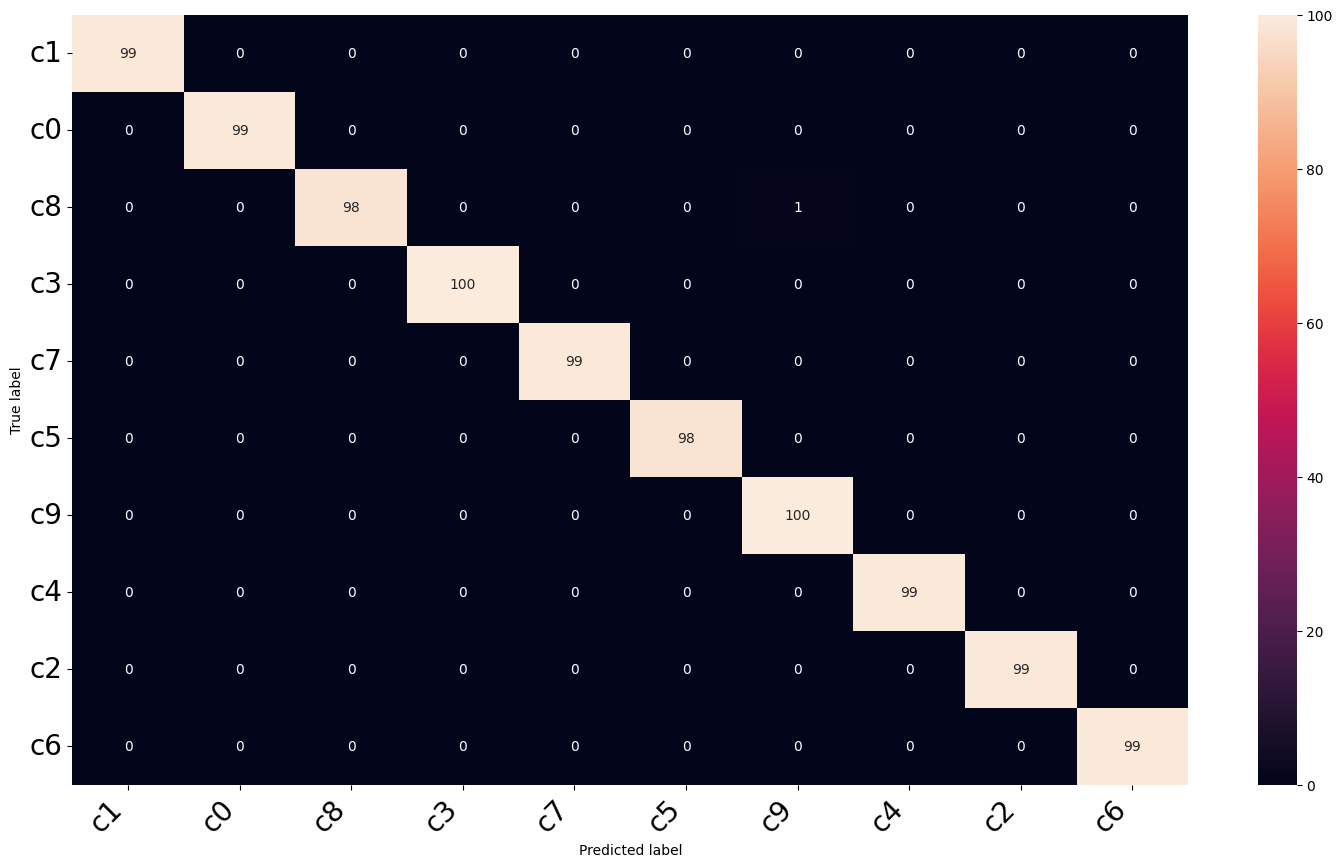

In [45]:
print_heatmap(ytest,ypred,class_names)

## Precision Recall F1 Score

In [46]:
ypred_class = np.argmax(ypred,axis=1)
# print(ypred_class[:10])
ytest = np.argmax(ytest,axis=1)

In [47]:
accuracy = accuracy_score(ytest,ypred_class)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(ytest, ypred_class,average='weighted')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(ytest,ypred_class,average='weighted')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(ytest,ypred_class,average='weighted')
print('F1 score: %f' % f1)

Accuracy: 0.994426
Precision: 0.994483
Recall: 0.994426
F1 score: 0.994430


In [59]:
from keras.models import load_model
from PIL import Image
import numpy as np

# Load the saved model (using raw string literal)
model_path = r'C:\Users\KUMAR\Desktop\cnn\Distracted-Driver-Detection\Training Notebooks\model\self_trained\distracted-05-0.99.hdf5'
model = load_model(model_path)

# Function to preprocess image for prediction
def preprocess_image(image_path):
    img = Image.open(image_path)  # Load image using PIL.Image
    img = img.resize((128, 128))  # Resize image
    x = np.array(img)  # Convert image to numpy array
    x = np.expand_dims(x, axis=0)  # Add batch dimension
    x = x / 255.0  # Normalize pixel values
    return x

# Example image path for prediction
image_path = r'C:\Users\KUMAR\Desktop\cnn\Distracted-Driver-Detection\Training Notebooks\imgs\test\img_102092.jpg'

# Preprocess the image
image_data = preprocess_image(image_path)

# Make predictions
predictions = model.predict(image_data)

# Interpret predictions (example for classification)
predicted_class = np.argmax(predictions, axis=1)
predicted_class_index = predicted_class[0]  # Extract the predicted class index
predicted_class_name = [name for name, idx in labels_id.items() if idx == predicted_class_index][0]
print('Predicted Class:', predicted_class_name)



1/1 [==============================] - 0s 67ms/step
Predicted Class: c5
